## Assignment 3 - Object Detection
By: Alec Pippas (awp251)

In [38]:
import cv2
import os
import csv
from ultralytics import YOLO

### Task 1: Object Detection of Car in Short Video

In [39]:
def split_video_to_frames(video_path, frames_folder):
    """
    Splits a video into frames and saves them into the specified folder.
    """
    os.makedirs(frames_folder, exist_ok=True)
    captured_vid = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        #reads one frame per iteration, .read() returns a tuple (ret, frame)
        # ret: boolean indicating if frame was successfully read
        # frame: frame image stored as NumPy array
        ret, frame = captured_vid.read()

        if not ret:
            break
        cv2.imwrite(os.path.join(frames_folder, f'frame_{frame_count:06d}.jpg'), frame) # save current frame withi the frames_folder
        frame_count += 1

    #free up resources (file handles, memory) associated with the cv2.VideoCaptuer object
    captured_vid.release() 
    return frame_count



def detect_and_annotate(frames_folder, processed_folder, model, total_frames, csv_file="detections.csv"):
    """
    Performs object detection on each frame using a YOLO model,
    draws bounding boxes (for cars) with centroids, saves new frames,
    and logs the car centroids to a CSV.
    """
    os.makedirs(processed_folder, exist_ok=True)

    # Open CSV for writing all detections (frame_idx, conf, cx, cy)
    with open(csv_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        # Write a header row (customize as you like)
        writer.writerow(["frame_idx", "conf", "cx", "cy"])

        for i in range(total_frames):
            frame_path = os.path.join(frames_folder, f'frame_{i:06d}.jpg')
            frame = cv2.imread(frame_path)
            if frame is None:
                continue

            # Run object detection
            results = model(frame)  # Optionally: model(frame, conf=0.6)

            # Draw bounding boxes and centroids
            for r in results:
                for box in r.boxes:
                    class_idx = int(box.cls[0])  # predicted class index
                    label = r.names[class_idx]   # class label (e.g., "car")
                    if label == "car":
                        x1, y1, x2, y2 = map(int, box.xyxy[0])
                        conf = float(box.conf[0])

                        # Draw bounding box
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

                        # Class label + confidence
                        text = f"{label} {conf:.2f}"
                        cv2.putText(frame, text, (x1, y1 - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                        # Compute and draw centroid
                        cx = (x1 + x2) // 2
                        cy = (y1 + y2) // 2
                        cv2.circle(frame, (cx, cy), 5, (0, 255, 0), -1)

                        # Write one row per detection to CSV
                        writer.writerow([i, f"{conf:.2f}", cx, cy])

            # Save the annotated frame
            cv2.imwrite(os.path.join(processed_folder, f'frame_{i:06d}.jpg'), frame)

In [40]:
def rebuild_video_from_frames(processed_folder, output_video, total_frames, fps=30):
    """
    Rebuilds a video from processed frames.
    """
    # Read the first frame to get size info
    first_frame_path = os.path.join(processed_folder, 'frame_000000.jpg')
    first_frame = cv2.imread(first_frame_path)
    
    #raise execption if the frame was not read (may indicate the frame was not extracted/processed correctly)
    if first_frame is None:
        raise FileNotFoundError(f"Could not read the file: {first_frame_path}")

    height, width, _ = first_frame.shape

    # Create VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Write each processed frame to the new video
    for i in range(total_frames):
        processed_frame_path = os.path.join(processed_folder, f'frame_{i:06d}.jpg')
        processed_frame = cv2.imread(processed_frame_path)
        if processed_frame is not None:
            out.write(processed_frame)

    out.release()

In [41]:
#1) Split the video into frames
video_path = "Assignment_3_video_ActiveTrack"
frames_folder = "extracted_frames"
total_frames = split_video_to_frames(video_path, frames_folder)

#2) Load a YOLO model (YOLOv8s pretrained on COCO)
model = YOLO("yolov8s.pt")

#3. Detect and annotate frames with bounding box + centroid for "car" objects
processed_folder = "processed_frames"
detect_and_annotate(frames_folder, processed_folder, model, total_frames)
                    
#4. Rebuild the annotated frames into a new video
output_video = "output_video.mp4"
rebuild_video_from_frames(processed_folder, output_video, total_frames, fps=30)
print(f"Object Detection with bounding boxes now complete. Annotated video has been savet to: {output_video}")


0: 640x384 1 bus, 44.1ms
Speed: 2.3ms preprocess, 44.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 29.7ms
Speed: 3.3ms preprocess, 29.7ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 30.1ms
Speed: 2.0ms preprocess, 30.1ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 23.5ms
Speed: 2.7ms preprocess, 23.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 20.5ms
Speed: 1.4ms preprocess, 20.5ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 20.3ms
Speed: 1.6ms preprocess, 20.3ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bus, 21.1ms
Speed: 1.5ms preprocess, 21.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bu

### Task 2: Kalman Filters with filterpy

In [51]:
import numpy as np
import math

from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [52]:
def initialize_kalman_filter(dt=1.0, process_var=1.0, measurement_var=5.0):
    """
    Initializes a 2D Kalman Filter tracking (x, y, vx, vy).
    dt: time step between frames (assume 1 frame per 'unit time')
    process_var: process (model) variance
    measurement_var: measurement variance
    """
    kf = KalmanFilter(dim_x=4, dim_z=2)
    
    # State vector: [x, y, vx, vy]
    # We'll initialize this dynamically once we get the first measurement.
    kf.x = np.array([0, 0, 0, 0], dtype=float)
    
    # State transition matrix (F)
    # [x]   [1  0  dt  0]
    # [y] = [0  1  0   dt]
    # [vx]  [0  0  1   0 ]
    # [vy]  [0  0  0   1 ]
    kf.F = np.array([[1, 0, dt, 0],
                     [0, 1, 0, dt],
                     [0, 0, 1, 0 ],
                     [0, 0, 0, 1 ]], dtype=float)
    
    # Measurement function (H)
    # We measure (x, y) only, so we map [x, y, vx, vy] -> [x, y].
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0]], dtype=float)
    
    # Covariance matrix (P)
    # Initialize with some large uncertainty for velocities.
    kf.P = np.eye(4) * 500.
    
    # R: measurement noise covariance
    # We assume measurement noise is the same for x and y
    kf.R = np.eye(2) * measurement_var
    
    # Q: process noise covariance
    # We'll generate some basic process noise for the velocity components
    q = Q_discrete_white_noise(dim=2, dt=dt, var=process_var)
    # Q_discrete_white_noise generates a 2x2 matrix for the subspace (vx, vy).
    # We need to embed it in a 4x4 for the full state.
    kf.Q = np.block([
        [np.zeros((2,2)),           np.zeros((2,2))],
        [np.zeros((2,2)),           q              ]
    ])
    
    return kf

In [53]:
def get_measurement_for_frame(bboxes, frame_idx):
    """
    Returns the (x, y) measurement for the given frame_idx
    or None if no measurement is available.
    """
    for (f_idx, x, y) in bboxes:
        if f_idx == frame_idx:
            return (x, y)
    return None

def rebuild_video(folder_path, output_video, total_frames, fps=30):
    """
    Rebuilds a video from frames in folder_path,
    saving it to output_video.
    """
    first_frame_path = os.path.join(folder_path, "frame_000000.jpg")
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        raise RuntimeError("No frames found to build video.")
    
    height, width, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for i in range(total_frames):
        frame_path = os.path.join(folder_path, f"frame_{i:06d}.jpg")
        frame = cv2.imread(frame_path)
        if frame is None:
            continue
        out.write(frame)
    
    out.release()

In [58]:
def load_bounding_box_centers(csv_file="detections.csv"):
    """
    Loads bounding box centers from a CSV file.
    It Expects columns: frame_idx, x_center, y_center.
    
    Returns:
        A list of tuples (frame_idx, x_center, y_center).
    """
    bounding_boxes = []

    with open(csv_file, 'r', newline='') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header row if exist
        for row in reader:
            frame_idx = int(row[0])
            x_center = float(row[2]) #centroid x_coordinate
            y_center = float(row[3])  #centroid y_coordinate
            bounding_boxes.append((frame_idx, x_center, y_center))
    return bounding_boxes


In [ ]:
def main():
    # --- 1. Prepare input paths ---
    # The folder with frames from the YOLO detection step
    processed_folder = "processed_frames"  # or "extracted_frames"
    # specify new folder to store frames with the Kalman-filtered track
    kalman_folder = "kalman_filtered_frames"
    os.makedirs(kalman_folder, exist_ok=True)
    
    # The bounding box data for each frame (x_center, y_center).  
    # Ex. bounding_boxes = [(0, 100, 200), (1, 101, 202), ...]
    bounding_boxes = load_bounding_box_centers("detections.csv")
    
    # Get Number of frames
    total_frames = len(os.listdir(processed_folder))
    
    # 2) Initialize Kalman Filter
    kf = initialize_kalman_filter(dt=1.0, process_var=1.0, measurement_var=5.0)
    initialized = False
    
    # We'll store the innovation norm to analyze filter performance
    innovation_norms = []
    
    # --- 3. Tracking Loop ---
    for i in range(total_frames):
        # Attempt to read bounding box center for frame i
        # If no detection is found for this frame, measurement = None
        measurement = get_measurement_for_frame(bounding_boxes, i)  # returns (x, y) or None
        
        # Kalman Filter: PREDICT step
        kf.predict()
        
        # If we do not have an initial measurement yet, we skip update
        # and just wait until we get a real measurement to initialize properly
        if not initialized and measurement is not None:
            # Initialize the filter state [x, y, vx, vy]
            kf.x[0] = measurement[0]
            kf.x[1] = measurement[1]
            kf.x[2] = 0.0
            kf.x[3] = 0.0 
            # velocities set to 0 or estimate if you prefer
            initialized = True
        
        # Kalman Filter: UPDATE step (if we have a new measurement)
        if measurement is not None and initialized:
            z = np.array([measurement[0], measurement[1]], dtype=float)
            
            # Compute predicted measurement for innovation
            z_pred = kf.H @ kf.x  # or kf.H.dot(kf.x)
            innovation = z - z_pred  # y = z - Hx
            # Store the norm of the 2D innovation
            innovation_magnitude = np.linalg.norm(innovation)
            innovation_norms.append(innovation_magnitude)
            
            # Now update the filter with the actual measurement
            kf.update(z)
        else:
            # If there's no measurement, we only have the prediction
            # or we're not yet initialized, so no update
            innovation_norms.append(None)  # No innovation for this step
        
        # --- 4. Draw the filtered centroid on the frame ---
        frame_path = os.path.join(processed_folder, f"frame_{i:06d}.jpg")
        frame = cv2.imread(frame_path)
        if frame is None:
            continue
        
        # Get the filter’s current best estimate (x, y)
        x_est, y_est, vx_est, vy_est = kf.x
        if initialized:
            # Draw a circle for the Kalman-estimated position
            cv2.circle(frame, (int(x_est), int(y_est)), 6, (0, 0, 255), -1)  # red circle
            cv2.putText(frame, "KF",
                        (int(x_est) + 10, int(y_est)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        # Optionally, also draw the raw YOLO measurement in a different color
        if measurement is not None:
            cv2.circle(frame, (int(measurement[0]), int(measurement[1])), 4, (255, 0, 0), -1)  # blue
        
        # Save the new frame with Kalman annotation
        out_path = os.path.join(kalman_folder, f"frame_{i:06d}.jpg")
        cv2.imwrite(out_path, frame)
    
    # 5) Rebuild the annotated video
    output_video = "kalman_output_video.mp4"
    rebuild_video(kalman_folder, output_video, total_frames, fps=30)
    
    print("Kalman filtering complete. Innovation norms:", innovation_norms)
    print(f"Output video saved to: {output_video}")


In [60]:
#run main
main()

Kalman filtering complete. Innovation norms: [None, None, None, None, None, None, None, None, None, None, None, 0.0, 1.0, None, None, None, None, None, None, None, None, None, None, None, None, None, 5.073767866125884, None, 0.5614483804855502, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 6.908589665459108, 2.543529730024819, None, None, None, None, None, None, 5.808801483744184, 4.096273009382025, 2.7973894043281677, 2.9787631137337294, 2.277730526855013, 2.6891516640531337, 2.1661533193347795, 2.6431223544431695, 2.1828726869439805, 1.8052554109685062, None, None, None, None, None, None, None, None, None, None, None, 0.5089902345051298, 0.2764601530394146, 0.1272960391571221, 0.08443738284337128, 1.508967004486005, 0.6892382261746632, 0.8453214660690003, 1.681709304386929, 1.6654256194857813, 1.286975006321671, 2.078119614679071, 2.028694934401208, 1.9984739136657628, 1.9270511933645975, 1.54665039202966, 2.06912526112923

### Task 3: Count Vehicular Traffic

In [ ]:
from pathlib import Path
from ultralytics.utils.downloads import download



# Download VisDrone Dataset
dir = Path("./datasets/VisDrone")  # dataset root dir

def visdrone2yolo(dir):
    """Convert VisDrone annotations to YOLO format, creating label files with normalized bounding box coordinates."""
    from PIL import Image
    from tqdm import tqdm
    def convert_box(size, box):
        # Convert VisDrone box to YOLO xywh box
        dw = 1.0 / size[0]
        dh = 1.0 / size[1]
        return (box[0] + box[2] / 2) * dw, (box[1] + box[3] / 2) * dh, box[2] * dw, box[3] * dh
    (dir / "labels").mkdir(parents=True, exist_ok=True)  # make labels directory
    pbar = tqdm((dir / "annotations").glob("*.txt"), desc=f"Converting {dir}")
    for f in pbar:
        img_size = Image.open((dir / "images" / f.name).with_suffix(".jpg")).size
        lines = []
        with open(f, encoding="utf-8") as file:  # read annotation.txt
            for row in [x.split(",") for x in file.read().strip().splitlines()]:
                if row[4] == "0":  # VisDrone 'ignored regions' class 0
                    continue
                cls = int(row[5]) - 1
                box = convert_box(img_size, tuple(map(int, row[:4])))
                lines.append(f"{cls} {' '.join(f'{x:.6f}' for x in box)}\n")
                with open(str(f).replace(f"{os.sep}annotations{os.sep}", f"{os.sep}labels{os.sep}"), "w", encoding="utf-8") as fl:
                    fl.writelines(lines)  # write label.txt

urls = [
    "https://github.com/ultralytics/assets/releases/download/v0.0.0/VisDrone2019-DET-train.zip",
    "https://github.com/ultralytics/assets/releases/download/v0.0.0/VisDrone2019-DET-val.zip",
    "https://github.com/ultralytics/assets/releases/download/v0.0.0/VisDrone2019-DET-test-dev.zip",
    "https://github.com/ultralytics/assets/releases/download/v0.0.0/VisDrone2019-DET-test-challenge.zip",
]
download(urls, dir=dir, curl=True, threads=4)
# Convert
for d in "VisDrone2019-DET-train", "VisDrone2019-DET-val", "VisDrone2019-DET-test-dev":
    visdrone2yolo(dir / d)  # convert VisDrone annotations to YOLO labels

Converting datasets/VisDrone/VisDrone2019-DET-train: 6471it [01:02, 102.79it/s]
Converting datasets/VisDrone/VisDrone2019-DET-val: 548it [00:07, 77.90it/s] 
Converting datasets/VisDrone/VisDrone2019-DET-test-dev: 1610it [00:15, 104.71it/s]


In [65]:
import matplotlib.pyplot as plt


# Centroid Tracker Class
class CentroidTracker:
    def __init__(self, maxDisappeared=50, maxDistance=50):
        self.nextObjectID = 0
        self.objects = {}      # objectID -> current centroid (x, y)
        self.disappeared = {}  # objectID -> consecutive frame count without detection
        self.maxDisappeared = maxDisappeared
        self.maxDistance = maxDistance
        self.tracks = {}       # objectID -> list of centroids (history)
        self.counted = {}      # objectID -> boolean flag if already counted

    def register(self, centroid):
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.tracks[self.nextObjectID] = [centroid]
        self.counted[self.nextObjectID] = False
        self.nextObjectID += 1

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.disappeared[objectID]
        del self.tracks[objectID]
        del self.counted[objectID]

    def update(self, inputCentroids):
        # If no new centroids, mark all existing objects as disappeared.
        if len(inputCentroids) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
            return self.objects

        # If no objects are currently tracked, register all input centroids.
        if len(self.objects) == 0:
            for centroid in inputCentroids:
                self.register(centroid)
            return self.objects

        # Compute distance between each existing object and new centroid.
        objectIDs = list(self.objects.keys())
        objectCentroids = list(self.objects.values())
        D = np.linalg.norm(np.array(objectCentroids)[:, np.newaxis] - np.array(inputCentroids), axis=2)

        # Find the smallest distances and match them.
        rows = D.min(axis=1).argsort()
        cols = D.argmin(axis=1)[rows]

        usedRows = set()
        usedCols = set()

        for (row, col) in zip(rows, cols):
            if row in usedRows or col in usedCols:
                continue
            if D[row, col] > self.maxDistance:
                continue
            objectID = objectIDs[row]
            self.objects[objectID] = inputCentroids[col]
            self.tracks[objectID].append(inputCentroids[col])
            self.disappeared[objectID] = 0
            usedRows.add(row)
            usedCols.add(col)

        # Mark unmatched existing objects as disappeared.
        unusedRows = set(range(0, D.shape[0])).difference(usedRows)
        for row in unusedRows:
            objectID = objectIDs[row]
            self.disappeared[objectID] += 1
            if self.disappeared[objectID] > self.maxDisappeared:
                self.deregister(objectID)

        # Register new objects for unmatched input centroids.
        unusedCols = set(range(0, D.shape[1])).difference(usedCols)
        for col in unusedCols:
            self.register(inputCentroids[col])

        return self.objects



In [85]:
import os
print(os.path.exists("../../runs/mlflow/647870279470109661/99b156ce37314ea9af73e146223fc2f3/artifacts/weights/best.pt"))


True


In [ ]:

# Main Vehicle Counting Pipeline Using Ultralytics YOLO

video_path = "Assignment3_Task3_video.mp4"           # Your input video file
frames_folder = "extracted_frames_car_count"         # Folder where frames will be stored
processed_folder = "processed_frames_car_count"      # Folder to save annotated frames
os.makedirs(processed_folder, exist_ok=True)

# 1. Split video into frames using the helper function.
total_frames = split_video_to_frames(video_path, frames_folder)
print(f"Total frames extracted: {total_frames}")

# 2. Get frame dimensions from the first frame.
first_frame_path = os.path.join(frames_folder, "frame_000000.jpg")
first_frame = cv2.imread(first_frame_path)
if first_frame is None:
    raise RuntimeError("Could not load the first frame.")
height, width, _ = first_frame.shape

# 3. Define the counting line (horizontal line across the frame).
line_y = int(height * 0.5)

# 4) Initialize the YOLO model (using Ultralytics YOLOv8) and vehicle label set.
model = YOLO("../../runs/mlflow/647870279470109661/99b156ce37314ea9af73e146223fc2f3/artifacts/weights/best.pt") 
vehicle_labels = {"car", "truck", "bus", "motorcycle", "motorbike"}

# 5) Initialize the centroid tracker and counters.
ct = CentroidTracker(maxDisappeared=30, maxDistance=50)
count_up = 0      # Vehicles moving upward (bottom to top)
count_down = 0    # Vehicles moving downward (top to bottom)

# For time series data.
time_series = []
counts_up_series = []
counts_down_series = []

# Retrieve fps from the video (using cv2.VideoCapture temporarily).
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()
duration = total_frames / fps

# 6) Process each extracted frame.
for i in range(total_frames):
    frame_path = os.path.join(frames_folder, f"frame_{i:06d}.jpg")
    frame = cv2.imread(frame_path)
    if frame is None:
        continue

    # Run YOLO detection on the frame.
    results = model(frame, conf=0.35)
    centroids = []
    # Iterate over detections.
    for r in results:
        for box in r.boxes:
            cls_idx = int(box.cls[0])
            label = r.names[cls_idx]
            if label in vehicle_labels:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cx = (x1 + x2) // 2
                cy = (y1 + y2) // 2
                centroids.append((cx, cy))
                # Draw detection bounding box and centroid.
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)

    # Update the centroid tracker.
    objects = ct.update(centroids)

    # Check each tracked object for line crossing.
    for objectID, centroid in objects.items():
        track = ct.tracks.get(objectID, [])
        if len(track) >= 2:
            prev_y = track[-2][1]
            curr_y = track[-1][1]
            if not ct.counted[objectID]:
                if prev_y < line_y and curr_y >= line_y:
                    count_down += 1
                    ct.counted[objectID] = True
                elif prev_y > line_y and curr_y <= line_y:
                    count_up += 1
                    ct.counted[objectID] = True

        # Optionally label tracked object.
        cv2.putText(frame, f"ID {objectID}", (centroid[0]-10, centroid[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
        cv2.circle(frame, (centroid[0], centroid[1]), 4, (255,255,0), -1)

    # Draw the counting line.
    cv2.line(frame, (0, line_y), (width, line_y), (0, 0, 255), 2)

    # Record counts for time series.
    time_series.append(i / fps)
    counts_up_series.append(count_up)
    counts_down_series.append(count_down)

    # Save the annotated frame.
    cv2.imwrite(os.path.join(processed_folder, f"frame_{i:06d}.jpg"), frame)



Total frames extracted: 726

0: 384x640 1 traffic light, 1 bottle, 36.6ms
Speed: 1.1ms preprocess, 36.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 35.2ms
Speed: 1.7ms preprocess, 35.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 bottle, 35.3ms
Speed: 1.9ms preprocess, 35.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 traffic light, 30.8ms
Speed: 1.4ms preprocess, 30.8ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 29.4ms
Speed: 1.8ms preprocess, 29.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 31.7ms
Speed: 1.2ms preprocess, 31.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.8ms
Speed: 1.8ms preprocess, 28.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.6ms
Sp

In [72]:
# 7) Normalize the counts by video duration
normalized_count_up = count_up / duration
normalized_count_down = count_down / duration

print("Video Duration (s):", duration)
print("Vehicles moving up:", count_up, "Normalized:", normalized_count_up)
print("Vehicles moving down:", count_down, "Normalized:", normalized_count_down)


Video Duration (s): 30.28025
Vehicles moving up: 0 Normalized: 0.0
Vehicles moving down: 0 Normalized: 0.0


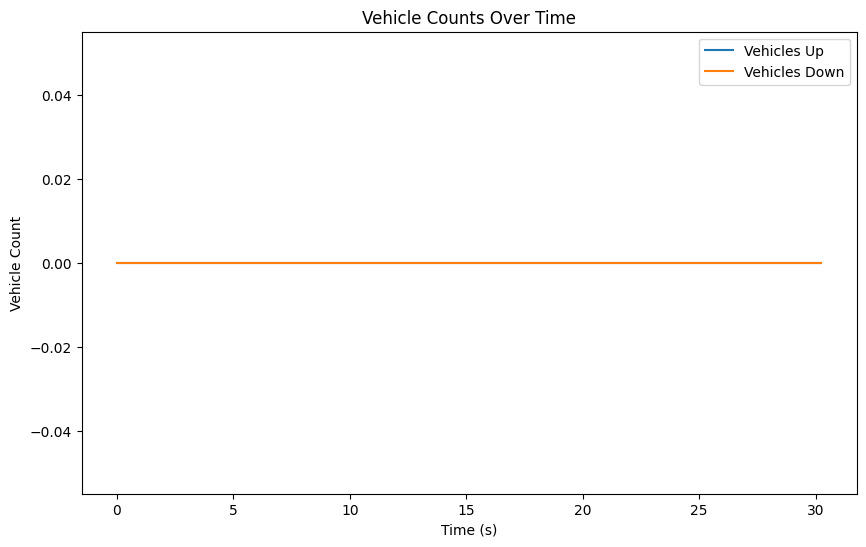

In [73]:
# 8) Plot the counts over time
plt.figure(figsize=(10, 6))
plt.plot(time_series, counts_up_series, label="Vehicles Up")
plt.plot(time_series, counts_down_series, label="Vehicles Down")
plt.xlabel("Time (s)")
plt.ylabel("Vehicle Count")
plt.title("Vehicle Counts Over Time")
plt.legend()
plt.show()
